https://github.com/roboflow/notebooks/blob/main/notebooks/how-to-run-different-vision-tasks-with-florence-2.ipynb

# Exploring Different Vision Tasks with Florence-2

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM  
from PIL import Image
import requests
import copy
import torch

In [ ]:
model_id = 'microsoft/Florence-2-large'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().to(device)
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

D:\win-ws\DL-KHU\.venv\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


generation_config.json:   0%|          | 0.00/51.0 [00:00<?, ?B/s]

D:\win-ws\DL-KHU\.venv\lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\user\.cache\huggingface\hub\models--microsoft--Florence-2-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/48.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-large:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

## define the prediction function

In [ ]:
def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

## init image 


In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

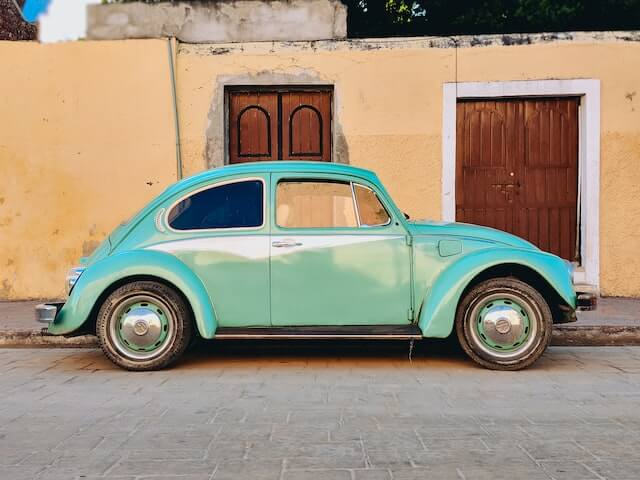

In [ ]:
image

## Run pre-defined tasks without additional inputs 

### Caption

In [ ]:
task_prompt = '<CAPTION>'
run_example(task_prompt)

{'<CAPTION>': 'a green volkswagen beetle parked in front of a yellow building'}

In [ ]:
task_prompt = '<DETAILED_CAPTION>'
run_example(task_prompt)

{'<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear blue sky.'}

In [ ]:
task_prompt = '<MORE_DETAILED_CAPTION>'
run_example(task_prompt)

{'<MORE_DETAILED_CAPTION>': 'The image shows a vintage Volkswagen Beetle car parked on a cobblestone street in front of a yellow building with two wooden doors. The car is painted in a bright turquoise color and has a white stripe running along the side. The doors are made of wood and have a rustic, weathered look. The building behind the car is also painted in the same shade of yellow and has two large windows. The sky is blue and there are trees in the background. The overall mood of the image is peaceful and serene.'}

### Object detection

OD results format: 
{'\<OD>':
    {
    'bboxes': [[x1, y1, x2, y2], ...], 
    'labels': ['label1', 'label2', ...]
    } 
}

In [ ]:
task_prompt = '<OD>'
results = run_example(task_prompt)
print(results)

{'<OD>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812]], 'labels': ['car', 'door handle']}}


In [ ]:
import matplotlib.pyplot as plt  
import matplotlib.patches as patches  
def plot_bbox(image, data):
   # Create a figure and axes  
    fig, ax = plt.subplots()  
      
    # Display the image  
    ax.imshow(image)  
      
    # Plot each bounding box  
    for bbox, label in zip(data['bboxes'], data['labels']):  
        # Unpack the bounding box coordinates  
        x1, y1, x2, y2 = bbox  
        # Create a Rectangle patch  
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')  
        # Add the rectangle to the Axes  
        ax.add_patch(rect)  
        # Annotate the label  
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))  
      
    # Remove the axis ticks and labels  
    ax.axis('off')  
      
    # Show the plot  
    plt.show()  

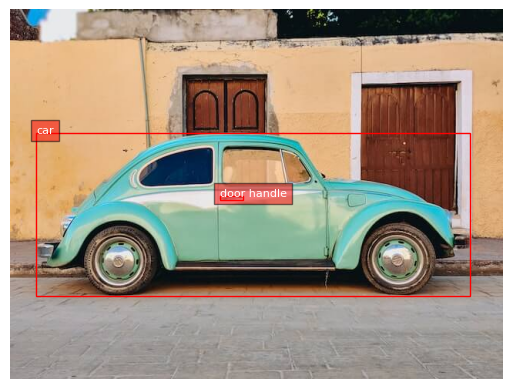

In [ ]:
plot_bbox(image, results['<OD>'])

### Dense region caption

Dense region caption results format: 
{'\<DENSE_REGION_CAPTION>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['label1', 'label2', ...]}}

In [ ]:
task_prompt = '<DENSE_REGION_CAPTION>'
results = run_example(task_prompt)
print(results)

{'<DENSE_REGION_CAPTION>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812]], 'labels': ['turquoise Volkswagen Beetle', 'door handle']}}


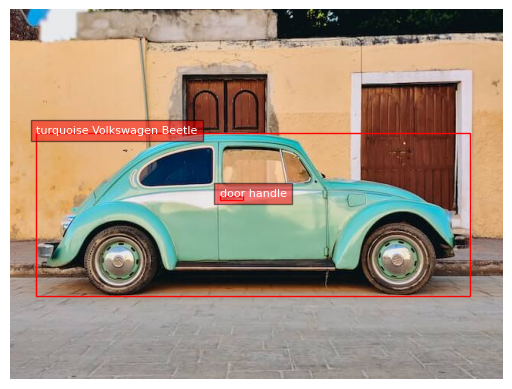

In [ ]:
plot_bbox(image, results['<DENSE_REGION_CAPTION>'])

### Region proposal

Region proposal results format: 
{'<REGION_PROPOSAL>' : {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [ ]:
task_prompt = '<REGION_PROPOSAL>'
results = run_example(task_prompt)
print(results)

{'<REGION_PROPOSAL>': {'bboxes': [[33.599998474121094, 160.55999755859375, 596.7999877929688, 371.7599792480469], [454.0799865722656, 276.7200012207031, 552.6400146484375, 370.79998779296875], [95.68000030517578, 280.55999755859375, 198.0800018310547, 371.2799987792969], [66.23999786376953, 266.6399841308594, 86.72000122070312, 295.91998291015625], [271.67999267578125, 242.1599884033203, 302.3999938964844, 246.95999145507812], [491.1999816894531, 183.59999084472656, 519.3599853515625, 187.44000244140625], [408.0, 308.3999938964844, 413.7599792480469, 320.8800048828125], [402.8800048828125, 212.39999389648438, 409.91998291015625, 219.59999084472656], [509.1199951171875, 172.0800018310547, 514.8800048828125, 176.39999389648438]], 'labels': ['', '', '', '', '', '', '', '', '']}}


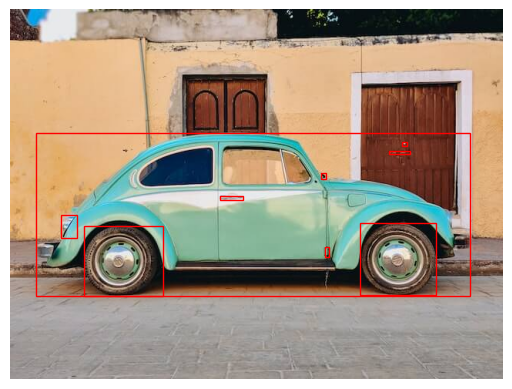

In [ ]:
plot_bbox(image, results['<REGION_PROPOSAL>'])

## Run pre-defined tasks that requires additional inputs 

### Phrase Grounding
Phrase grounding results format: 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}

In [ ]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="A green car parked in front of a yellow building.")
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[34.880001068115234, 159.1199951171875, 582.0800170898438, 374.6399841308594], [1.5999999046325684, 4.559999942779541, 639.0399780273438, 304.55999755859375]], 'labels': ['A green car', 'a yellow building']}}


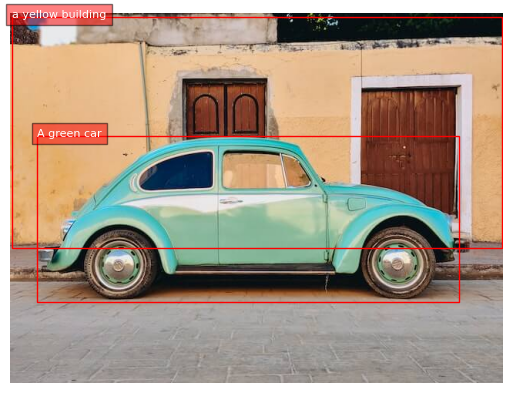

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Referring expression segmentation

Referring expression segmentation results format: 
{'\<REFERRING_EXPRESSION_SEGMENTATION>': {'Polygons': [[[polygon]], ...], 'labels': ['', '', ...]}}, one object is represented by a list of polygons. each polygon is [x1, y1, x2, y2, ..., xn, yn]

In [ ]:
task_prompt = '<REFERRING_EXPRESSION_SEGMENTATION>'
results = run_example(task_prompt, text_input="a green car")
# print(results)

In [ ]:
from PIL import Image, ImageDraw, ImageFont 
import random
import numpy as np
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']
def draw_polygons(image, prediction, fill_mask=False):  
    """  
    Draws segmentation masks with polygons on an image.  
  
    Parameters:  
    - image_path: Path to the image file.  
    - prediction: Dictionary containing 'polygons' and 'labels' keys.  
                  'polygons' is a list of lists, each containing vertices of a polygon.  
                  'labels' is a list of labels corresponding to each polygon.  
    - fill_mask: Boolean indicating whether to fill the polygons with color.  
    """  
    # Load the image  
   
    draw = ImageDraw.Draw(image)  
      
   
    # Set up scale factor if needed (use 1 if not scaling)  
    scale = 1  
      
    # Iterate over polygons and labels  
    for polygons, label in zip(prediction['polygons'], prediction['labels']):  
        color = random.choice(colormap)  
        fill_color = random.choice(colormap) if fill_mask else None  
          
        for _polygon in polygons:  
            _polygon = np.array(_polygon).reshape(-1, 2)  
            if len(_polygon) < 3:  
                print('Invalid polygon:', _polygon)  
                continue  
              
            _polygon = (_polygon * scale).reshape(-1).tolist()  
              
            # Draw the polygon  
            if fill_mask:  
                draw.polygon(_polygon, outline=color, fill=fill_color)  
            else:  
                draw.polygon(_polygon, outline=color)  
              
            # Draw the label text  
            draw.text((_polygon[0] + 8, _polygon[1] + 2), label, fill=color)  
  
    # Save or display the image  
    #image.show()  # Display the image  
    display(image)

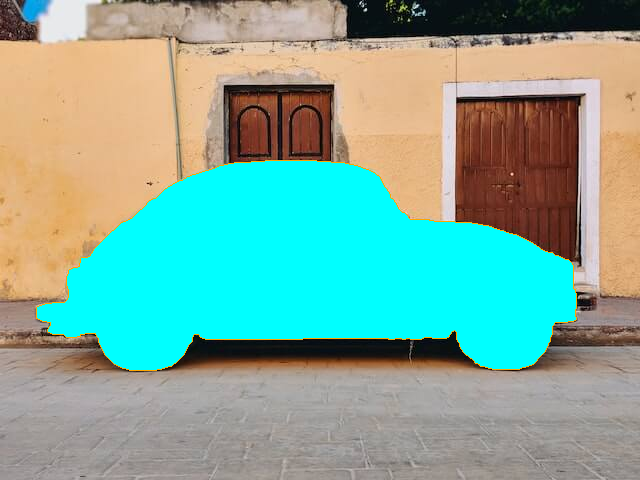

In [ ]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REFERRING_EXPRESSION_SEGMENTATION>'], fill_mask=True)  

### region to segmentation


with additional region as inputs, format is '\<loc_x1>\<loc_y1>\<loc_x2>\<loc_y2>', [x1, y1, x2, y2] is the quantized corrdinates in [0, 999]. 

In [ ]:
task_prompt = '<REGION_TO_SEGMENTATION>'
results = run_example(task_prompt, text_input="<loc_702><loc_575><loc_866><loc_772>")
print(results)

{'<REGION_TO_SEGMENTATION>': {'polygons': [[[470.7200012207031, 288.239990234375, 473.91998291015625, 285.8399963378906, 477.1199951171875, 283.91998291015625, 479.03997802734375, 282.9599914550781, 480.9599914550781, 282.9599914550781, 484.1600036621094, 281.0400085449219, 486.7200012207031, 280.0799865722656, 489.91998291015625, 279.1199951171875, 495.03997802734375, 278.1600036621094, 512.9599609375, 278.1600036621094, 516.1599731445312, 279.1199951171875, 519.3599853515625, 281.0400085449219, 520.6400146484375, 281.0400085449219, 527.0399780273438, 283.91998291015625, 530.239990234375, 285.8399963378906, 533.4400024414062, 288.239990234375, 541.760009765625, 296.8800048828125, 544.3200073242188, 300.239990234375, 546.239990234375, 303.1199951171875, 548.1599731445312, 306.9599914550781, 548.7999877929688, 309.8399963378906, 550.0800170898438, 312.7200012207031, 550.719970703125, 317.03997802734375, 550.719970703125, 333.8399963378906, 550.0800170898438, 338.1600036621094, 548.79998

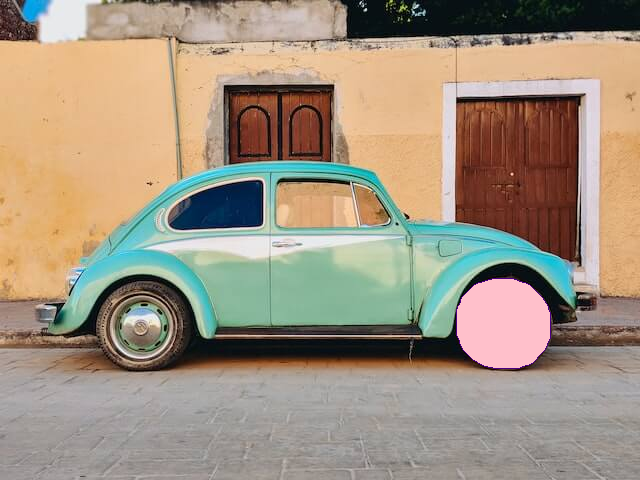

In [ ]:
output_image = copy.deepcopy(image)
draw_polygons(output_image, results['<REGION_TO_SEGMENTATION>'], fill_mask=True)  

### Open vocabulary detection

open vocabulary detection can detect both objects and ocr texts. 

results format: 

{ '\<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[x1, y1, x2, y2], [x1, y1, x2, y2], ...]], 'bboxes_labels': ['label_1', 'label_2', ..],
'polygons': [[[x1, y1, x2, y2, ..., xn, yn], [x1, y1, ..., xn, yn]], ...], 'polygons_labels': ['label_1', 'label_2', ...]
}}

In [ ]:
task_prompt = '<OPEN_VOCABULARY_DETECTION>'
results = run_example(task_prompt, text_input="a green car")
print(results)

{'<OPEN_VOCABULARY_DETECTION>': {'bboxes': [[34.23999786376953, 158.63999938964844, 581.4400024414062, 373.67999267578125]], 'bboxes_labels': ['a green car'], 'polygons': [], 'polygons_labels': []}}


In [ ]:
def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

In [ ]:
bbox_results  = convert_to_od_format(results['<OPEN_VOCABULARY_DETECTION>'])

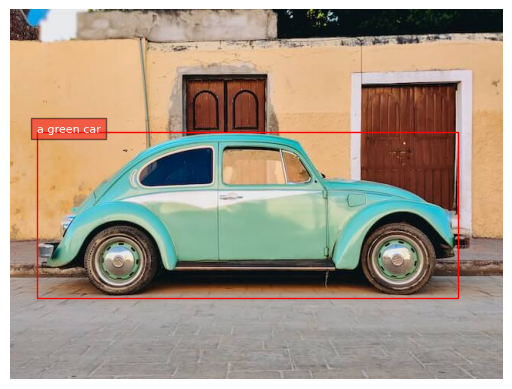

In [ ]:
plot_bbox(image, bbox_results)

### region to texts

In [ ]:
task_prompt = '<REGION_TO_CATEGORY>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_CATEGORY>': 'car<loc_52><loc_332><loc_932><loc_774>'}


In [ ]:
task_prompt = '<REGION_TO_DESCRIPTION>'
results = run_example(task_prompt, text_input="<loc_52><loc_332><loc_932><loc_774>")
print(results)

{'<REGION_TO_DESCRIPTION>': 'turquoise Volkswagen Beetle<loc_52><loc_332><loc_932><loc_774>'}


## ocr related tasks

In [ ]:
url = "http://ecx.images-amazon.com/images/I/51UUzBDAMsL.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw).convert('RGB')

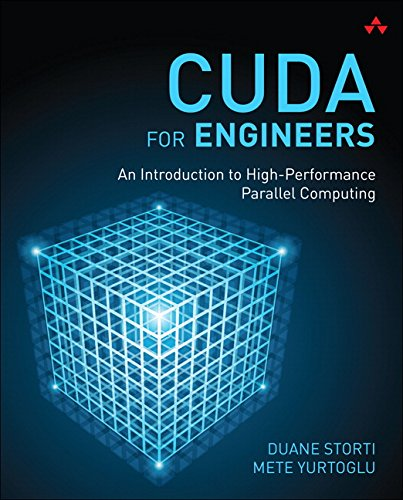

In [ ]:
image

In [ ]:
task_prompt = '<OCR>'
run_example(task_prompt)

{'<OCR>': 'CUDA\nFOR ENGINEERS\nAn Introduction to High-Performance\nParallel Computing\nDUANE STORTI\nMETE YURTOGLU\n'}

In [ ]:
task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results)
# ocr results format
# {'OCR_WITH_REGION': {'quad_boxes': [[x1, y1, x2, y2, x3, y3, x4, y4], ...], 'labels': ['text1', ...]}}

{'<OCR_WITH_REGION>': {'quad_boxes': [[167.44650268554688, 50.25, 374.9914855957031, 50.25, 374.9914855957031, 114.25, 167.44650268554688, 114.25], [144.8784942626953, 121.25, 374.9914855957031, 120.25, 374.9914855957031, 149.25, 144.8784942626953, 150.25], [115.4594955444336, 165.25, 375.7974853515625, 165.25, 375.7974853515625, 183.25, 115.4594955444336, 183.25], [239.9864959716797, 184.25, 375.7974853515625, 185.25, 375.7974853515625, 203.25, 239.9864959716797, 201.25], [265.77850341796875, 440.75, 375.7974853515625, 440.75, 375.7974853515625, 456.25, 265.77850341796875, 456.25], [250.86749267578125, 459.25, 375.7974853515625, 459.25, 375.7974853515625, 474.25, 250.86749267578125, 474.25]], 'labels': ['</s>CUDA', 'FOR ENGINEERS', 'An Introduction to High-Performance', 'Parallel Computing', 'DUANE STORTI', 'METE YURTOGLU']}}


In [ ]:
def draw_ocr_bboxes(image, prediction, scale=1):
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
       
    display(image)

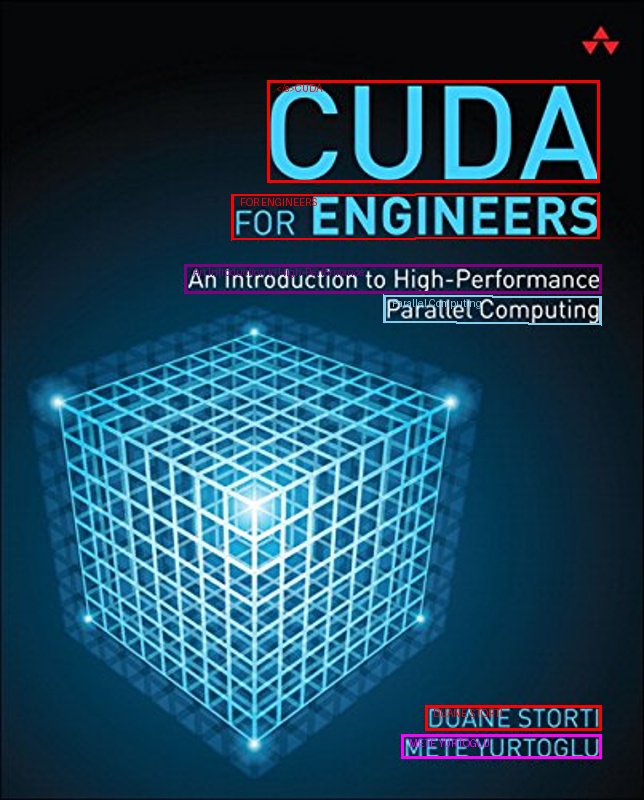

In [ ]:
output_image = copy.deepcopy(image)
w, h = output_image.size
scale = 800 / max(w, h)
new_output_image = output_image.resize((int(w * scale), int(h * scale)))
draw_ocr_bboxes(new_output_image, results['<OCR_WITH_REGION>'], scale=scale)  

## Cascaded tasks

### Caption + Phrase Grounding 

results format: 

{
 '\<CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg?download=true"
image = Image.open(requests.get(url, stream=True).raw)

In [ ]:
task_prompt = '<CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[33.599998474121094,
    158.63999938964844,
    582.0800170898438,
    374.6399841308594],
   [1.5999999046325684,
    4.559999942779541,
    638.3999633789062,
    305.5199890136719]],
  'labels': ['a green volkswagen beetle', 'a yellow building']},
 '<CAPTION>': 'a green volkswagen beetle parked in front of a yellow building'}

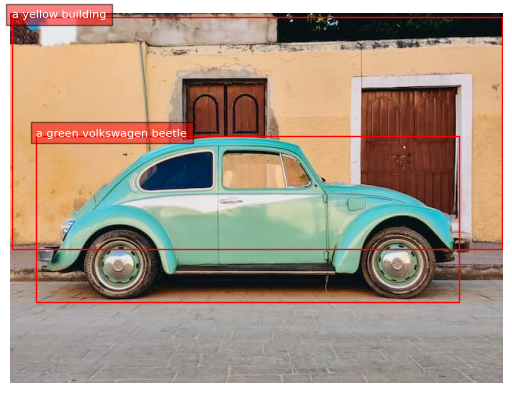

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### Detailed Caption + Phrase Grounding 

results format: 

{
 '\<DETAILED_CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
task_prompt = '<DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<DETAILED_CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[33.599998474121094,
    159.1199951171875,
    582.0800170898438,
    375.1199951171875],
   [1.5999999046325684,
    4.559999942779541,
    638.3999633789062,
    305.5199890136719],
   [453.44000244140625,
    94.79999542236328,
    582.0800170898438,
    265.1999816894531],
   [223.67999267578125,
    84.72000122070312,
    335.03997802734375,
    166.8000030517578],
   [344.0, 1.1999999284744263, 638.3999633789062, 40.55999755859375],
   [17.600000381469727,
    1.1999999284744263,
    638.3999633789062,
    43.91999816894531],
   [19.520000457763672,
    1.1999999284744263,
    104.63999938964844,
    45.36000061035156]],
  'labels': ['a green Volkswagen Beetle',
   'a yellow building',
   'brown doors',
   'brown doors',
   'trees',
   'a clear blue sky',
   'a clear blue sky']},
 '<DETAILED_CAPTION>': 'The image shows a green Volkswagen Beetle parked in front of a yellow building with two brown doors, surrounded by trees and a clear

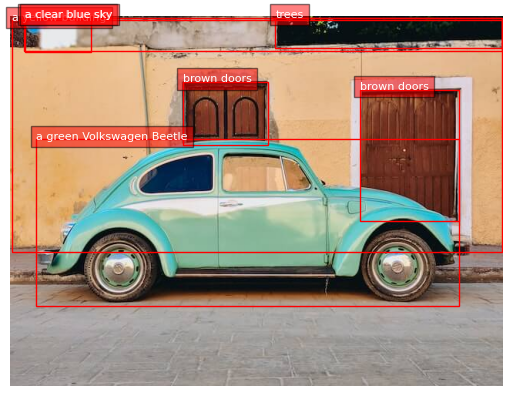

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

### More Detailed Caption + Phrase Grounding 

results format: 

{
 '\<MORE_DETAILED_CAPTION': pure_text, 
{'\<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[x1, y1, x2, y2], ...], 'labels': ['', '', ...]}}
}

In [ ]:
task_prompt = '<MORE_DETAILED_CAPTION>'
results = run_example(task_prompt)
text_input = results[task_prompt]
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input)
results['<MORE_DETAILED_CAPTION>'] = text_input

In [ ]:
results

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[36.15999984741211,
    158.16000366210938,
    580.1599731445312,
    372.7200012207031],
   [2.240000009536743,
    340.55999755859375,
    637.1199951171875,
    477.3599853515625],
   [454.0799865722656,
    93.83999633789062,
    580.7999877929688,
    262.32000732421875],
   [36.15999984741211,
    157.67999267578125,
    579.5199584960938,
    372.239990234375],
   [221.1199951171875,
    79.91999816894531,
    583.3599853515625,
    263.7599792480469],
   [454.0799865722656,
    93.83999633789062,
    581.4400024414062,
    262.32000732421875],
   [223.67999267578125,
    83.75999450683594,
    333.7599792480469,
    163.44000244140625],
   [2.879999876022339, 4.559999942779541, 636.47998046875, 300.239990234375],
   [19.520000457763672,
    0.7199999690055847,
    102.07999420166016,
    42.47999954223633],
   [345.91998291015625,
    0.7199999690055847,
    637.1199951171875,
    37.20000076293945]],
  'labels': ['a vintage Volksw

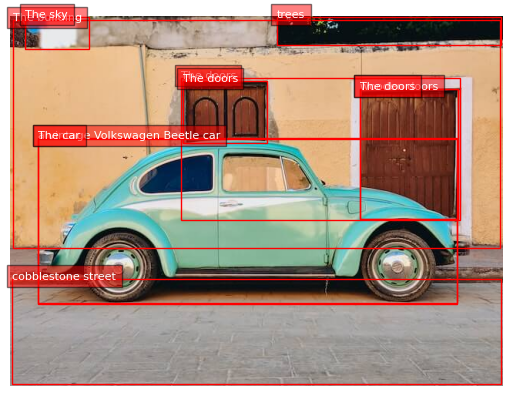

In [ ]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])